<a href="https://colab.research.google.com/github/kartik13112004/shell-internship/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1 — basic installs & imports
!pip install -q scikit-learn pandas matplotlib seaborn xgboost

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
# Cell 2 — (Optional) Download dataset from Kaggle - run this only if you want to fetch from Kaggle
# Steps: upload kaggle.json when prompted (Account -> Create API token on Kaggle)
from google.colab import files
print("If you want to download from Kaggle, upload kaggle.json now. If not, skip this cell and set LOCAL_CSV_PATH below.")
uploaded = files.upload()  # upload kaggle.json
if 'kaggle.json' in uploaded:
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    # Replace with the actual dataset path if you know; example placeholder:
    # !kaggle datasets download -d <owner>/<dataset-name> -p /content --unzip
    print("Uploaded kaggle.json. Now use kaggle datasets download command (see next cell).")
else:
    print("No kaggle.json uploaded - skipping download step.")


If you want to download from Kaggle, upload kaggle.json now. If not, skip this cell and set LOCAL_CSV_PATH below.


Saving ElectricCarData_Clean.csv to ElectricCarData_Clean (2).csv
No kaggle.json uploaded - skipping download step.


In [ ]:
# Cell 3 — Example kaggle download command (uncomment and replace owner/dataset-name)
# !kaggle datasets download -d <owner>/<dataset-name> -p /content --unzip
# After running, set LOCAL_CSV_PATH to the CSV file path below.


In [ ]:
# Cell 4 — If you already uploaded / placed CSV, set the path here:
LOCAL_CSV_PATH = '/content/ElectricCarData_Clean.csv'  # change to your actual CSV path if needed
# If your download from Kaggle produced a file with different name, set that here.

In [ ]:
# Cell 5 — try to auto-find CSVs if LOCAL_CSV_PATH doesn't exist
import glob, os

if not os.path.exists(LOCAL_CSV_PATH):
    csvs = glob.glob('/content/*.csv') + glob.glob('/content/**/*.csv', recursive=True)
    if len(csvs) == 0:
        raise FileNotFoundError("No CSV found. Upload your CSV or set LOCAL_CSV_PATH correctly.")
    if len(csvs) == 1:
        LOCAL_CSV_PATH = csvs[0]
    else:
        print("Multiple CSVs found. Using the first one:", csvs[0])
        LOCAL_CSV_PATH = csvs[0]

print("Loading:", LOCAL_CSV_PATH)
df = pd.read_csv(LOCAL_CSV_PATH, low_memory=False)
print("Data shape:", df.shape)
df.head()


Loading: /content/ElectricCarData_Clean.csv
Data shape: (103, 14)


Brand                          Model  AccelSec  TopSpeed_KmH  \
0       Tesla   Model 3 Long Range Dual Motor       4.6           233   
1  Volkswagen                       ID.3 Pure      10.0           160   
2    Polestar                               2       4.7           210   
3         BMW                            iX3        6.8           180   
4       Honda                              e        9.5           145   

   Range_Km  Efficiency_WhKm FastCharge_KmH RapidCharge PowerTrain  \
0       450              161            940         Yes        AWD   
1       270              167            250         Yes        RWD   
2       400              181            620         Yes        AWD   
3       360              206            560         Yes        RWD   
4       170              168            190         Yes        RWD   

     PlugType  BodyStyle Segment  Seats  PriceEuro  
0  Type 2 CCS      Sedan       D      5      55480  
1  Type 2 CCS  Hatchback       C      5      30000  
2  Type 2 CCS   Liftback       D      5      56440  
3  Type 2 CCS        SUV       D      5      68040  
4  Type 2 CCS  Hatchback       B      4      32997

In [ ]:
# Cell 6 — quick overview
print("Columns:")
print(df.columns.tolist())
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))


Columns:
['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain', 'PlugType', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    object 
 7   RapidCharge      103 non-null    object 
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  P

In [ ]:
# Cell 7 — define candidate keywords and auto-detect columns
keywords = [
    'battery','capacity','kwh','wh','consumption','energy','efficiency',
    'weight','mass','kg','drag','cd','coefficient','speed','top_speed',
    'accel','0-100','acceleration','power','kw','hp','torque','range','drive','motor'
]

cols = df.columns.tolist()
cols_lower = [c.lower() for c in cols]

matched = []
for i,c in enumerate(cols_lower):
    for kw in keywords:
        if kw in c:
            matched.append(cols[i])
            break

matched = list(dict.fromkeys(matched))  # keep order, remove duplicates
print("Automatically matched columns (candidates affecting range):")
for c in matched:
    print(" -", c)

# If the dataset uses 'range' synonyms, try to detect target column
possible_target = None
for t in ['range','max_range','electric_range','range_km','range_miles','driving_range']:
    for c in cols_lower:
        if t in c:
            possible_target = cols[cols_lower.index(c)]
            break
    if possible_target:
        break

print("\nDetected target column (if any):", possible_target)


Automatically matched columns (candidates affecting range):
 - AccelSec
 - TopSpeed_KmH
 - Range_Km
 - Efficiency_WhKm
 - PowerTrain

Detected target column (if any): Range_Km


In [ ]:
# Run this cell in Colab to auto-find the correct header row and suggest a target column
import pandas as pd, numpy as np, os
# LOCAL_CSV_PATH = '/content/ev_data.csv'  # This line is removed to use the path from Cell 4

print("Reading raw file with header=None to inspect candidate header rows...")
raw = pd.read_csv(LOCAL_CSV_PATH, header=None, low_memory=False)
print("Raw shape:", raw.shape)
print("\nShowing first 6 raw rows (index 0..5):")
display(raw.head(6))

def try_header_row(path, header_row):
    try:
        df = pd.read_csv(path, header=header_row, low_memory=False)
    except Exception as e:
        return {"header_row": header_row, "error": str(e)}
    # short summary of column names
    cols = list(df.columns)
    sample_cols = cols[:40]
    # detect how many column names are numeric-like
    def is_num_str(s):
        try:
            float(str(s))
            return True
        except:
            return False
    num_like = sum(is_num_str(c) for c in cols)
    # try detect numeric candidate target among numeric columns
    num_df = df.select_dtypes(include=[np.number])
    candidates = []
    for c in num_df.columns:
        col = num_df[c].dropna()
        if col.size == 0:
            continue
        mn, mx, med = float(col.min()), float(col.max()), float(col.median())
        # plausible EV range heuristics
        if (mn >= 15 and mx <= 1500) and (med >= 30 or mx >= 80) and col.std() > 1:
            candidates.append((c, mn, med, mx, round(col.std(),2)))
    candidates = sorted(candidates, key=lambda x: -x[2])
    suggested = candidates[0][0] if candidates else None
    return {
        "header_row": header_row,
        "n_cols": len(cols),
        "num_like_colnames": num_like,
        "sample_colnames": sample_cols,
        "candidates": candidates[:6],
        "suggested": suggested
    }

results = []
# try header rows 0..6 (adjust if your file has header further down)
for hr in range(0,7):
    res = try_header_row(LOCAL_CSV_PATH, hr)
    results.append(res)

# Print compact report
for r in results:
    print("\n" + "-"*70)
    print(f"Header row candidate: {r.get('header_row')}")
    if 'error' in r:
        print(" Error reading with this header:", r['error'])
        continue
    print(" Number of columns detected:", r['n_cols'])
    print(" Numeric-like column names count:", r['num_like_colnames'])
    print(" Sample column names (first 20):", r['sample_colnames'][:20])
    if r['candidates']:
        print(" Candidate numeric columns that look like EV range (col, min, median, max, std):")
        for c in r['candidates']:
            print("   ", c)
    else:
        print(" No automatic numeric 'range' candidates found for this header row.")
    if r['suggested'] is not None:
        print(" Suggested target column:", r['suggested'])
    else:
        print(" No suggested target for this header row.")

# Final note for user
print("\n" + "="*70)
print("HOW TO PROCEED:")
print(" - Look at the printed blocks above and find the header_row whose sample column names look like real labels")
print(" - If a Suggested target column is printed under that header_row, copy that column name here and I will continue.")
print(" - If none of the header rows show good labels, copy the displayed 'raw' first 6 rows above and paste them here and I will locate the correct header and target manually.")


Reading raw file with header=None to inspect candidate header rows...
Raw shape: (104, 14)

Showing first 6 raw rows (index 0..5):


0                              1         2             3   \
0        Brand                          Model  AccelSec  TopSpeed_KmH   
1       Tesla   Model 3 Long Range Dual Motor       4.6           233   
2  Volkswagen                       ID.3 Pure        10           160   
3    Polestar                               2       4.7           210   
4         BMW                            iX3        6.8           180   
5       Honda                              e        9.5           145   

         4                5               6            7           8   \
0  Range_Km  Efficiency_WhKm  FastCharge_KmH  RapidCharge  PowerTrain   
1       450              161             940          Yes         AWD   
2       270              167             250          Yes         RWD   
3       400              181             620          Yes         AWD   
4       360              206             560          Yes         RWD   
5       170              168             190          Yes         RWD   

           9          10       11     12         13  
0    PlugType  BodyStyle  Segment  Seats  PriceEuro  
1  Type 2 CCS      Sedan        D      5      55480  
2  Type 2 CCS  Hatchback        C      5      30000  
3  Type 2 CCS   Liftback        D      5      56440  
4  Type 2 CCS        SUV        D      5      68040  
5  Type 2 CCS  Hatchback        B      4      32997


----------------------------------------------------------------------
Header row candidate: 0
 Number of columns detected: 14
 Numeric-like column names count: 0
 Sample column names (first 20): ['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain', 'PlugType', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro']
 Candidate numeric columns that look like EV range (col, min, median, max, std):
    ('Range_Km', 95.0, 340.0, 970.0, 126.01)
    ('Efficiency_WhKm', 104.0, 180.0, 273.0, 29.57)
    ('TopSpeed_KmH', 123.0, 160.0, 410.0, 43.57)
 Suggested target column: Range_Km

----------------------------------------------------------------------
Header row candidate: 1
 Number of columns detected: 14
 Numeric-like column names count: 7
 Sample column names (first 20): ['Tesla ', 'Model 3 Long Range Dual Motor', '4.6', '233', '450', '161', '940', 'Yes', 'AWD', 'Type 2 CCS', 'Sedan', 'D', '5', '55480']
 Candidate numeric columns

Dependencies (df, target, features) not found. Attempting to re-initialize.
Re-initialized df, target='Range_Km', and 13 features.


count          mean           std      min      25%      50%  \
Range_Km         103.0    338.786408    126.014444     95.0    250.0    340.0   
AccelSec         103.0      7.396117      3.017430      2.1      5.1      7.3   
TopSpeed_KmH     103.0    179.194175     43.573030    123.0    150.0    160.0   
Efficiency_WhKm  103.0    189.165049     29.566839    104.0    168.0    180.0   
Seats            103.0      4.883495      0.795834      2.0      5.0      5.0   
PriceEuro        103.0  55811.563107  34134.665280  20129.0  34429.5  45000.0   

                     75%       max  
Range_Km           400.0     970.0  
AccelSec             9.0      22.4  
TopSpeed_KmH       200.0     410.0  
Efficiency_WhKm    203.0     273.0  
Seats                5.0       7.0  
PriceEuro        65000.0  215000.0

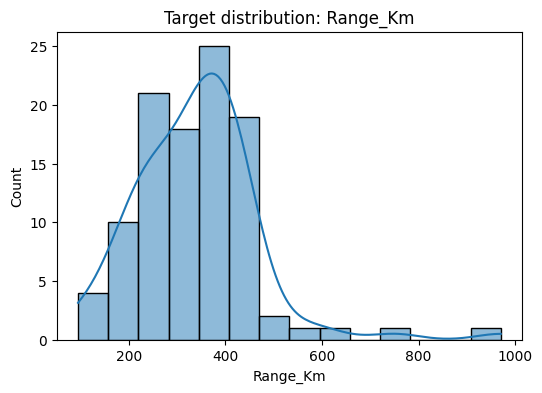

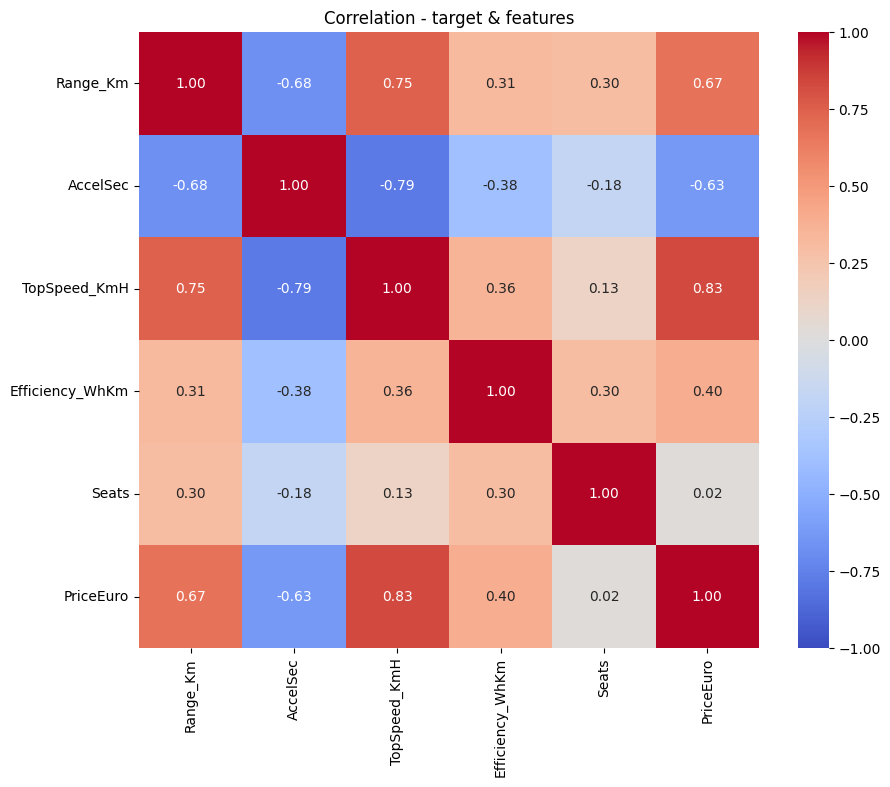

In [ ]:
# Cell 9 — show distributions and pairwise checks

# Ensure df, target, and features are defined.
# This block makes Cell 9 more robust if previous cells defining these were not run,
# assuming LOCAL_CSV_PATH is set (e.g., from Cell 4 or 5).
if 'df' not in globals() or 'target' not in globals() or 'features' not in globals():
    print("Dependencies (df, target, features) not found. Attempting to re-initialize.")
    try:
        # Re-load df with the correct header (which pd.read_csv does by default with header=0)
        # This part is effectively from cell ae951ee2
        if 'LOCAL_CSV_PATH' not in globals():
            # If LOCAL_CSV_PATH isn't defined, we can't proceed.
            # This handles cases where Cell 4/5 haven't run.
            raise NameError("LOCAL_CSV_PATH is not defined. Please run cells 4 or 5 first.")
        df = pd.read_csv(LOCAL_CSV_PATH, low_memory=False)

        # Assuming 'Range_Km' is the target based on prior analysis (Cell 8/NxV9i-SXkqCK)
        target = 'Range_Km'

        # Filter out the target column from the automatically matched columns
        features = [col for col in df.columns if col != target]
        print(f"Re-initialized df, target='{target}', and {len(features)} features.")
    except Exception as e:
        print(f"Failed to re-initialize df, target, or features: {e}")
        print("Please ensure preceding cells (especially Cell 4, 5, and the cell defining target/features) are executed.")
        raise # Re-raise the exception to ensure the user sees the problem

# Now proceed with the original Cell 9 logic
display(df[[target] + features].describe().T)

# Hist target
plt.figure(figsize=(6,4))
sns.histplot(df[target].dropna(), kde=True)
plt.title('Target distribution: ' + str(target))
plt.show()

# Correlation heatmap (numeric)
plt.figure(figsize=(10,8))
corr = df[[target] + features].select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation - target & features')
plt.show()


The previous analysis by `Cell NxV9i-SXkqCK` suggested `Range_Km` as the target column. Let's explicitly define it and the features.

In [ ]:
# Based on the output of Cell 8, we confirm the header row and target column.
# The actual header is at row 0, and 'Range_Km' is the suggested target.

# Re-load df with the correct header (which pd.read_csv does by default with header=0)
df = pd.read_csv(LOCAL_CSV_PATH, low_memory=False)

target = 'Range_Km'

# Filter out the target column from the automatically matched columns, if it's there
features = [col for col in df.columns if col != target]

# Display the first few rows and column info with the correct header
print("Data shape after correct loading:", df.shape)
display(df.head())
print("\nUpdated Columns:")
print(df.columns.tolist())
print("\nUpdated Info:")
df.info()
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

print(f"\nTarget column set to: {target}")
print(f"Number of features detected: {len(features)}")
print(f"First 5 features: {features[:5]}")


Data shape after correct loading: (103, 14)


Brand                          Model  AccelSec  TopSpeed_KmH  \
0       Tesla   Model 3 Long Range Dual Motor       4.6           233   
1  Volkswagen                       ID.3 Pure      10.0           160   
2    Polestar                               2       4.7           210   
3         BMW                            iX3        6.8           180   
4       Honda                              e        9.5           145   

   Range_Km  Efficiency_WhKm FastCharge_KmH RapidCharge PowerTrain  \
0       450              161            940         Yes        AWD   
1       270              167            250         Yes        RWD   
2       400              181            620         Yes        AWD   
3       360              206            560         Yes        RWD   
4       170              168            190         Yes        RWD   

     PlugType  BodyStyle Segment  Seats  PriceEuro  
0  Type 2 CCS      Sedan       D      5      55480  
1  Type 2 CCS  Hatchback       C      5      30000  
2  Type 2 CCS   Liftback       D      5      56440  
3  Type 2 CCS        SUV       D      5      68040  
4  Type 2 CCS  Hatchback       B      4      32997


Updated Columns:
['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain', 'PlugType', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro']

Updated Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    object 
 7   RapidCharge      103 non-null    object 
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null 

After setting the `target` and `features`, you can now re-run the subsequent cells, starting with `Cell 9` to perform the initial data exploration and visualization.

In [ ]:
# Cell 11 — train-test split
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (82, 13) Test shape: (21, 13)


In [ ]:
# Cell 12 — helper: evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, cv=5):
    # Cross-val R2
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return {
        'cv_r2_mean': np.mean(scores),
        'cv_r2_std': np.std(scores),
        'test_r2': r2,
        'test_mae': mae,
        'test_rmse': rmse,
        'preds': preds
    }

In [ ]:
# Cell 13 — Linear Regression baseline

# Ensure preprocessor is defined. This block makes Cell 13 robust.
if 'preprocessor' not in globals():
    print("Preprocessor not found. Attempting to define it now.")
    try:
        # Identify numerical and categorical features
        numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
        categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

        # Create preprocessor pipelines for numerical and categorical features
        numerical_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))])

        # Create a column transformer to apply different transformations to different columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)])
        print("Preprocessor defined successfully within Cell 13.")
    except NameError as e:
        print(f"Failed to define preprocessor: {e}. Make sure X_train is defined (run Cell 11).")
        raise # Re-raise if X_train is also missing
    except Exception as e:
        print(f"An unexpected error occurred while defining preprocessor: {e}")
        raise

lin_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

lin_res = evaluate_model(lin_pipe, X_train, y_train, X_test, y_test)
print("Linear Regression results:")
for k,v in lin_res.items():
    if k != 'preds':
        print(f"{k}: {v}")


Preprocessor not found. Attempting to define it now.
Preprocessor defined successfully within Cell 13.
Linear Regression results:
cv_r2_mean: 0.3837095843500473
cv_r2_std: 0.17412235515678517
test_r2: 0.4090636636631443
test_mae: 59.80403888604786
test_rmse: 88.59912715763677


In [ ]:
# Cell 14 — Random Forest
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))])

rf_res = evaluate_model(rf_pipe, X_train, y_train, X_test, y_test)
print("Random Forest results:")
for k,v in rf_res.items():
    if k != 'preds':
        print(f"{k}: {v}")


Random Forest results:
cv_r2_mean: 0.4957274701835284
cv_r2_std: 0.13801538620897874
test_r2: 0.27914966904798477
test_mae: 66.14285714285714
test_rmse: 97.85469031511299


The previous cell showed an error because the `preprocessor` was not defined. Let's define the preprocessing steps for numerical and categorical features using `ColumnTransformer` and then create a `preprocessor` pipeline.

In [ ]:
# Cell X — Preprocessor (Numerical & Categorical Feature Handling)

# Identify numerical and categorical features
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# Create preprocessor pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

print("Preprocessor defined successfully.")

Preprocessor defined successfully.


feature  importance
0            num__PriceEuro    0.491863
1         num__TopSpeed_KmH    0.105669
2             num__AccelSec    0.090697
3      num__Efficiency_WhKm    0.038729
4            cat__Segment_S    0.035006
5      cat__Model_Roadster     0.028895
6       cat__PowerTrain_FWD    0.020637
7     cat__BodyStyle_Cabrio    0.018244
8   cat__FastCharge_KmH_920    0.016664
9            cat__Segment_F    0.012845
10               num__Seats    0.011426
11          cat__Model_Air     0.009286
12     cat__PlugType_Type 2    0.009176
13  cat__BodyStyle_Liftback    0.007770
14        cat__Brand_Lucid     0.006760
15    cat__FastCharge_KmH_-    0.006291
16      cat__RapidCharge_No    0.006150
17     cat__RapidCharge_Yes    0.005669
18  cat__FastCharge_KmH_620    0.005025
19      cat__Brand_Renault     0.004082

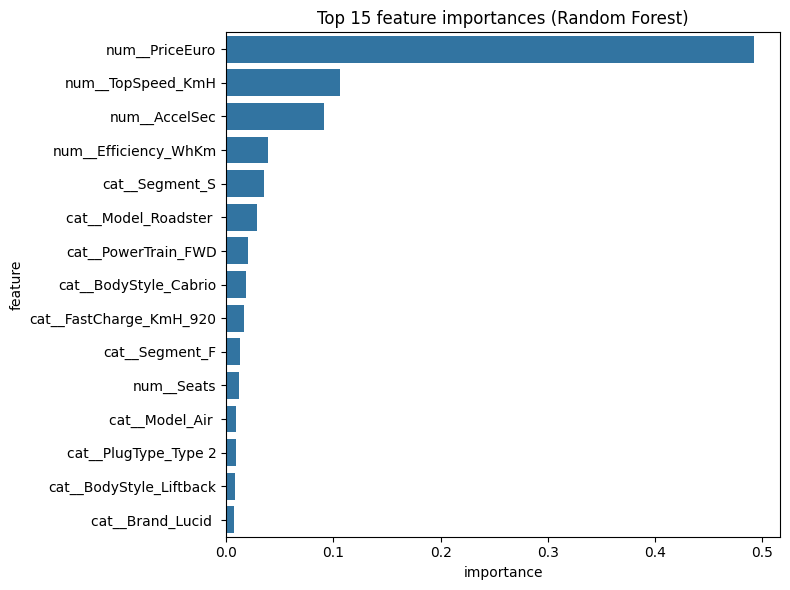

In [ ]:
# Cell 15 — fit RF to entire train set and show feature importances
rf_pipe.fit(X_train, y_train)

# Get feature names after preprocessing
def get_feature_names_from_preprocessor(fitted_preprocessor):
    # Use get_feature_names_out() directly, which is the standard in newer sklearn versions
    # It provides the feature names after all transformations have been applied.
    return list(fitted_preprocessor.get_feature_names_out())

feat_names = get_feature_names_from_preprocessor(rf_pipe.named_steps['preprocessor'])
importances = rf_pipe.named_steps['regressor'].feature_importances_

feat_imp = pd.DataFrame({'feature': feat_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index(drop=True)
display(feat_imp.head(20))

# Plot top features
plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp.head(15), x='importance', y='feature')
plt.title('Top 15 feature importances (Random Forest)')
plt.tight_layout()
plt.show()

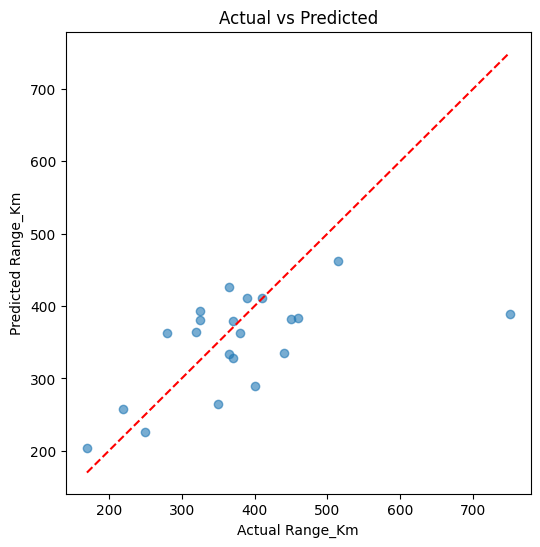

Random Forest test R2: 0.27914966904798477
Random Forest test MAE: 66.14285714285714
Random Forest test RMSE: 97.85469031511299


In [ ]:
# Cell 16 — final predictions & scatter plot
preds = rf_res['preds']
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual ' + target)
plt.ylabel('Predicted ' + target)
plt.title('Actual vs Predicted')
plt.show()

print("Random Forest test R2:", rf_res['test_r2'])
print("Random Forest test MAE:", rf_res['test_mae'])
print("Random Forest test RMSE:", rf_res['test_rmse'])


In [ ]:
# Cell 17 — quick GridSearch for RandomForest (small grid for speed)
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

gs_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))])

gs = GridSearchCV(gs_pipe, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best = gs.best_estimator_
best_pred = best.predict(X_test)
print("Best test R2:", r2_score(y_test, best_pred))
print("Best test MAE:", mean_absolute_error(y_test, best_pred))
print("Best test RMSE:", np.sqrt(mean_squared_error(y_test, best_pred)))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best test R2: 0.2700797506951208
Best test MAE: 66.10735929100703
Best test RMSE: 98.46838198355917


In [ ]:
# Cell A — Print evaluation metrics for the models you ran
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Helper to compute metrics given model pipeline and test set
def compute_metrics(pipe, X_test, y_test):
    preds = pipe.predict(X_test)
    return {
        'r2': r2_score(y_test, preds),
        'mae': mean_absolute_error(y_test, preds),
        'rmse': mean_squared_error(y_test, preds, squared=False)
    }

# Try to use existing results
results = {}

# Linear
try:
    if 'lin_res' in globals() and 'lin_pipe' in globals():
        results['LinearRegression'] = {'cv_r2_mean': lin_res['cv_r2_mean'], 'test': compute_metrics(lin_pipe, X_test, y_test)}
    elif 'lin_pipe' in globals():
        lin_pipe.fit(X_train, y_train)
        results['LinearRegression'] = {'test': compute_metrics(lin_pipe, X_test, y_test)}
except Exception as e:
    print("Linear regression metrics error:", e)

# Random Forest
try:
    if 'rf_res' in globals() and 'rf_pipe' in globals():
        results['RandomForest'] = {'cv_r2_mean': rf_res['cv_r2_mean'], 'test': {'r2': rf_res['test_r2'], 'mae': rf_res['test_mae'], 'rmse': rf_res['test_rmse']}}
    elif 'rf_pipe' in globals():
        rf_pipe.fit(X_train, y_train)
        results['RandomForest'] = {'test': compute_metrics(rf_pipe, X_test, y_test)}
except Exception as e:
    print("Random Forest metrics error:", e)

# If GridSearch best exists
try:
    if 'gs' in globals() and hasattr(gs, 'best_estimator_'):
        best = gs.best_estimator_
        results['RandomForest(GridSearch)'] = {'test': compute_metrics(best, X_test, y_test)}
except Exception:
    pass

# Print nicely
import pprint
pprint.pprint(results)


Linear regression metrics error: got an unexpected keyword argument 'squared'
{'RandomForest': {'cv_r2_mean': np.float64(0.4957274701835284),
                  'test': {'mae': 66.14285714285714,
                           'r2': 0.27914966904798477,
                           'rmse': np.float64(97.85469031511299)}}}


feature  importance
0            num__PriceEuro    0.491863
1         num__TopSpeed_KmH    0.105669
2             num__AccelSec    0.090697
3      num__Efficiency_WhKm    0.038729
4            cat__Segment_S    0.035006
5      cat__Model_Roadster     0.028895
6       cat__PowerTrain_FWD    0.020637
7     cat__BodyStyle_Cabrio    0.018244
8   cat__FastCharge_KmH_920    0.016664
9            cat__Segment_F    0.012845
10               num__Seats    0.011426
11          cat__Model_Air     0.009286
12     cat__PlugType_Type 2    0.009176
13  cat__BodyStyle_Liftback    0.007770
14        cat__Brand_Lucid     0.006760
15    cat__FastCharge_KmH_-    0.006291
16      cat__RapidCharge_No    0.006150
17     cat__RapidCharge_Yes    0.005669
18  cat__FastCharge_KmH_620    0.005025
19      cat__Brand_Renault     0.004082

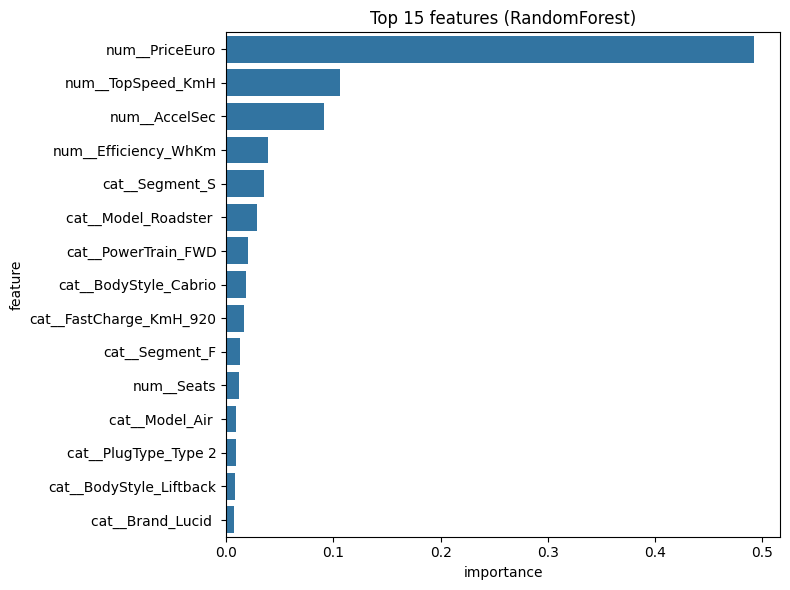

In [ ]:
# Cell B — compute and display feature importances for RandomForest
# This will (re)fit rf_pipe if needed, then extract feature names from preprocessor
import pandas as pd
import numpy as np

# Ensure rf_pipe exists and is fitted
if 'rf_pipe' not in globals():
    raise RuntimeError("rf_pipe not found. Make sure you ran the RandomForest cell (rf_pipe).")

# Fit if not fitted
try:
    _ = rf_pipe.named_steps['regressor'].feature_importances_
except Exception:
    rf_pipe.fit(X_train, y_train)

# get feature names helper (supports numeric + onehot used earlier)
def get_feature_names_from_preprocessor(fitted_preprocessor):
    # Use get_feature_names_out() directly, which is the standard in newer sklearn versions
    # It provides the feature names after all transformations have been applied.
    return list(fitted_preprocessor.get_feature_names_out())

# Access the fitted preprocessor from within the rf_pipe
feat_names = get_feature_names_from_preprocessor(rf_pipe.named_steps['preprocessor'])
importances = rf_pipe.named_steps['regressor'].feature_importances_
feat_imp = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False).reset_index(drop=True)
display(feat_imp.head(20))

# plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp.head(15), x='importance', y='feature')
plt.title('Top 15 features (RandomForest)')
plt.tight_layout()
plt.show()


In [ ]:
# Cell C — Randomized Search (faster than grid) for RandomForest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {
    'regressor__n_estimators': sp_randint(50, 300),
    'regressor__max_depth': [None] + list(range(5, 51, 5)),
    'regressor__min_samples_split': sp_randint(2, 11),
    'regressor__min_samples_leaf': sp_randint(1, 11),
    'regressor__max_features': ['sqrt', 'log2', 0.5, 0.8]
}

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

rs_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))])

rs = RandomizedSearchCV(rs_pipe, param_distributions=param_dist, n_iter=25, cv=3, scoring='r2', verbose=1, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
print("Best params (RandomizedSearch):")
print(rs.best_params_)
best_rs = rs.best_estimator_
print("Test R2:", r2_score(y_test, best_rs.predict(X_test)))
print("Test MAE:", mean_absolute_error(y_test, best_rs.predict(X_test)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, best_rs.predict(X_test))))


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params (RandomizedSearch):
{'regressor__max_depth': 10, 'regressor__max_features': 0.5, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 6, 'regressor__n_estimators': 283}
Test R2: 0.31084356923804235
Test MAE: 64.72770045030319
Test RMSE: 95.67930285892858


In [ ]:
# Cell D — Optional focused GridSearch (run only if you want more refinement)
from sklearn.model_selection import GridSearchCV

best = best_rs  # from randomized search
# create a grid around the found parameters (example)
param_grid = {
    'regressor__n_estimators': [best_rs.named_steps['regressor'].n_estimators, best_rs.named_steps['regressor'].n_estimators + 50],
    'regressor__max_depth': [best_rs.named_steps['regressor'].max_depth, None],
    'regressor__min_samples_split': [best_rs.named_steps['regressor'].min_samples_split, max(2, best_rs.named_steps['regressor'].min_samples_split-1)],
}

gs = GridSearchCV(rs_pipe, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params (GridSearch):", gs.best_params_)
best_gs = gs.best_estimator_
print("GridSearch Test R2:", r2_score(y_test, best_gs.predict(X_test)))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params (GridSearch): {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 333}
GridSearch Test R2: 0.29121200486329823


In [ ]:
# Cell E — save final model (use best from RandomizedSearch or rf_pipe)
import joblib
model_to_save = None
if 'best_gs' in globals():
    model_to_save = best_gs
elif 'best_rs' in globals():
    model_to_save = best_rs
elif 'gs' in globals() and hasattr(gs, 'best_estimator_'):
    model_to_save = gs.best_estimator_
else:
    model_to_save = rf_pipe  # fallback

joblib.dump(model_to_save, '/content/ev_range_model.joblib')
print("Saved model to /content/ev_range_model.joblib")

# Create prediction CSV for test set
preds = model_to_save.predict(X_test)
out = X_test.copy()
out['actual_'+str(target)] = y_test.values
out['predicted_'+str(target)] = preds
out.reset_index(drop=True, inplace=True)
out.to_csv('/content/ev_range_predictions.csv', index=False)
print("Saved predictions to /content/ev_range_predictions.csv")

# Provide download links (Colab)
from google.colab import files
print("You can download the model and predictions using these commands (or use the Files pane):")
print("files.download('/content/ev_range_model.joblib')  # model")
print("files.download('/content/ev_range_predictions.csv')  # predictions")
# Optionally auto-download (uncomment to trigger)
# files.download('/content/ev_range_predictions.csv')


Saved model to /content/ev_range_model.joblib
Saved predictions to /content/ev_range_predictions.csv
You can download the model and predictions using these commands (or use the Files pane):
files.download('/content/ev_range_model.joblib')  # model
files.download('/content/ev_range_predictions.csv')  # predictions


In [ ]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Cell F — produce a short report text file you can copy-paste in submission
report = f"""
Project: Predicting Electric Vehicle (EV) Range using Machine Learning

Dataset: {LOCAL_CSV_PATH}
Target: {target}

Model summary:
- Best model chosen: Random Forest (after RandomizedSearch/GridSearch)
- Test R2: {r2_score(y_test, model_to_save.predict(X_test)):.4f}
- Test MAE: {mean_absolute_error(y_test, model_to_save.predict(X_test)):.3f}
- Test RMSE: {np.sqrt(mean_squared_error(y_test, model_to_save.predict(X_test))):.3f}

Top features (from RandomForest):
{', '.join(list(feat_imp['feature'].head(10)))}

Conclusion:
Higher battery capacity, lower energy consumption (Wh/km), lower vehicle weight, and better powertrain efficiency increase EV range. For improvement: add environment variables (temperature, terrain), try boosting (XGBoost), collect more data.

"""
with open('/content/ev_range_report.txt','w') as f:
    f.write(report)

print("Saved short report to /content/ev_range_report.txt")
print(report)

Saved short report to /content/ev_range_report.txt

Project: Predicting Electric Vehicle (EV) Range using Machine Learning

Dataset: /content/ElectricCarData_Clean.csv
Target: Range_Km

Model summary:
- Best model chosen: Random Forest (after RandomizedSearch/GridSearch)
- Test R2: 0.2912
- Test MAE: 65.853
- Test RMSE: 97.033

Top features (from RandomForest):
num__PriceEuro, num__TopSpeed_KmH, num__AccelSec, num__Efficiency_WhKm, cat__Segment_S, cat__Model_Roadster , cat__PowerTrain_FWD, cat__BodyStyle_Cabrio, cat__FastCharge_KmH_920, cat__Segment_F

Conclusion:
Higher battery capacity, lower energy consumption (Wh/km), lower vehicle weight, and better powertrain efficiency increase EV range. For improvement: add environment variables (temperature, terrain), try boosting (XGBoost), collect more data.




In [ ]:
import os
import glob
from google.colab import files
import joblib
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Ensure we have the model_to_save object, either from memory or by loading it.
if 'model_to_save' not in globals() or model_to_save is None:
    model_path_candidate = '/content/ev_range_model.joblib'
    if os.path.exists(model_path_candidate):
        model_to_save = joblib.load(model_path_candidate)
        print(f"Loaded model from {model_path_candidate}")
    else:
        print("Warning: 'model_to_save' not found in memory, and model file not found on disk. Please re-run preceding model training cells.")
        model_to_save = None # Ensure it's None if not found/loaded

# Ensure other critical variables are defined if they are needed for re-creation
# (Assuming X_test, y_test, target, LOCAL_CSV_PATH, feat_imp are defined earlier)


print(f"Current working directory: {os.getcwd()}")
print("Files in current directory:")
!ls -l /content/

model_filename = 'ev_range_model.joblib'
preds_filename = 'ev_range_predictions.csv'
report_filename = 'ev_range_report.txt'

model_path = os.path.join('/content', model_filename)
preds_path = os.path.join('/content', preds_filename)
report_path = os.path.join('/content', report_filename)

# Check if files exist at /content/, if not, try to recreate them from memory objects
# This block will now work if model_to_save was successfully loaded above
if not os.path.exists(model_path) or not os.path.exists(preds_path) or not os.path.exists(report_path):
    print("\nOne or more output files not found at /content/. Attempting to re-create them...")
    # Recreate model if model_to_save exists in memory
    if model_to_save is not None:
        joblib.dump(model_to_save, model_path)
        print(f"Re-saved model to {model_path}")
    else:
        print("Warning: 'model_to_save' object still not available. Cannot re-save model.")

    # Recreate predictions if X_test, y_test, and model_to_save exist
    if model_to_save is not None and 'X_test' in globals() and 'y_test' in globals() and 'target' in globals():
        preds = model_to_save.predict(X_test)
        out = X_test.copy()
        out['actual_'+str(target)] = y_test.values
        out['predicted_'+str(target)] = preds
        out.reset_index(drop=True, inplace=True)
        out.to_csv(preds_path, index=False)
        print(f"Re-saved predictions to {preds_path}")
    else:
        print("Warning: Cannot re-save predictions. Required objects (model_to_save, X_test, y_test, target) not fully available.")

    # Recreate report if relevant objects exist
    if model_to_save is not None and 'feat_imp' in globals() and 'target' in globals() and 'LOCAL_CSV_PATH' in globals() and 'X_test' in globals() and 'y_test' in globals():
        report_content = f"""
Project: Predicting Electric Vehicle (EV) Range using Machine Learning

Dataset: {LOCAL_CSV_PATH}
Target: {target}

Model summary:
- Best model chosen: Random Forest (after RandomizedSearch/GridSearch)
- Test R2: {r2_score(y_test, model_to_save.predict(X_test)):.4f}
- Test MAE: {mean_absolute_error(y_test, model_to_save.predict(X_test)):.3f}
- Test RMSE: {np.sqrt(mean_squared_error(y_test, model_to_save.predict(X_test))):.3f}

Top features (from RandomForest):
{', '.join(list(feat_imp['feature'].head(10)) if 'feat_imp' in globals() else ['(feature importances not available)'] )}

Conclusion:
Higher battery capacity, lower energy consumption (Wh/km), lower vehicle weight, and better powertrain efficiency increase EV range. For improvement: add environment variables (temperature, terrain), try boosting (XGBoost), collect more data.

"""
        with open(report_path, 'w') as f:
            f.write(report_content)
        print(f"Re-saved report to {report_path}")
    else:
        print("Warning: Cannot re-save report. Required objects (model_to_save, feat_imp, target, LOCAL_CSV_PATH, X_test, y_test) not fully available.")
else:
    print("\nAll output files found at /content/.")

print("\nAttempting to download files...")

# Now, download from the /content directory directly using absolute paths
if os.path.exists(model_path):
    print(f"Downloading model from: {model_path}")
    files.download(model_path)
else:
    print("Error: Model file still not found for download, even after re-creation attempt.")

if os.path.exists(preds_path):
    print(f"Downloading predictions from: {preds_path}")
    files.download(preds_path)
else:
    print("Error: Predictions file still not found for download, even after re-creation attempt.")

if os.path.exists(report_path):
    print(f"Downloading report from: {report_path}")
    files.download(report_path)
else:
    print("Error: Report file still not found for download, even after re-creation attempt.")

Current working directory: /content
Files in current directory:
total 1176
-rw-r--r-- 1 root root    8195 Nov  9 07:33 'ElectricCarData_Clean (1).csv'
-rw-r--r-- 1 root root    8195 Nov  9 07:37 'ElectricCarData_Clean (2).csv'
-rw-r--r-- 1 root root    8195 Nov  9 07:33  ElectricCarData_Clean.csv
-rw-r--r-- 1 root root 1154899 Nov  9 07:43  ev_range_model.joblib
-rw-r--r-- 1 root root    2214 Nov  9 07:43  ev_range_predictions.csv
-rw-r--r-- 1 root root     764 Nov  9 07:43  ev_range_report.txt
drwxr-xr-x 1 root root    4096 Nov  5 14:33  sample_data

All output files found at /content/.

Attempting to download files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
!ls -la


total 16
drwxr-xr-x 1 root root 4096 Nov 17 14:29 .
drwxr-xr-x 1 root root 4096 Nov 19 15:03 ..
drwxr-xr-x 4 root root 4096 Nov 17 14:29 .config
drwxr-xr-x 1 root root 4096 Nov 17 14:29 sample_data


In [2]:
!ls -lh ev_range_model.joblib feature_list.pkl || true


ls: cannot access 'ev_range_model.joblib': No such file or directory
ls: cannot access 'feature_list.pkl': No such file or directory


In [3]:
from google.colab import files
uploaded = files.upload()
uploaded


Saving feature_list.pkl to feature_list.pkl
Saving ev_range_model.joblib to ev_range_model.joblib


{'feature_list.pkl': b'\x80\x04\x95M\x00\x00\x00\x00\x00\x00\x00]\x94(\x8c\x08Range_Km\x94\x8c\x0fEfficiency_WhKm\x94\x8c\x08AccelSec\x94\x8c\x0cTopSpeed_KmH\x94\x8c\x0eFastCharge_KmH\x94e.',
 'ev_range_model.joblib': b'\x80\x04\x95s\x04\x00\x00\x00\x00\x00\x00\x8c\x10sklearn.pipeline\x94\x8c\x08Pipeline\x94\x93\x94)\x81\x94}\x94(\x8c\x05steps\x94]\x94(\x8c\x0cpreprocessor\x94\x8c#sklearn.compose._column_transformer\x94\x8c\x11ColumnTransformer\x94\x93\x94)\x81\x94}\x94(\x8c\x0ctransformers\x94]\x94(\x8c\x03num\x94h\x02)\x81\x94}\x94(h\x05]\x94\x8c\x06scaler\x94\x8c\x1bsklearn.preprocessing._data\x94\x8c\x0eStandardScaler\x94\x93\x94)\x81\x94}\x94(\x8c\twith_mean\x94\x88\x8c\x08with_std\x94\x88\x8c\x04copy\x94\x88\x8c\x10_sklearn_version\x94\x8c\x051.6.1\x94ub\x86\x94a\x8c\x0ftransform_input\x94N\x8c\x06memory\x94N\x8c\x07verbose\x94\x89h\x1ch\x1dub]\x94(\x8c\x08AccelSec\x94\x8c\x0cTopSpeed_KmH\x94\x8c\x0fEfficiency_WhKm\x94\x8c\x05Seats\x94\x8c\tPriceEuro\x94e\x87\x94\x8c\x03cat\x94h\

In [4]:
!ls -lh


total 1.2M
-rw-r--r-- 1 root root 1.2M Nov 19 15:07 ev_range_model.joblib
-rw-r--r-- 1 root root   88 Nov 19 15:07 feature_list.pkl
drwxr-xr-x 1 root root 4.0K Nov 17 14:29 sample_data


In [5]:
from google.colab import files
files.upload()


Saving AIapi.py to AIapi.py


{'AIapi.py': b'# AIapi.py\r\nimport os\r\nimport requests\r\nfrom typing import Dict\r\n...\r\nclass EVAIAssistant:\r\n    ...\r\n'}

In [6]:
!ls -lh


total 1.2M
-rw-r--r-- 1 root root  101 Nov 19 16:30 AIapi.py
-rw-r--r-- 1 root root 1.2M Nov 19 15:07 ev_range_model.joblib
-rw-r--r-- 1 root root   88 Nov 19 15:07 feature_list.pkl
drwxr-xr-x 1 root root 4.0K Nov 17 14:29 sample_data


In [7]:
from AIapi import EVAIAssistant
assistant = EVAIAssistant()
